In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm

In [2]:
from scipy.stats.stats import pearsonr 

In [3]:
matplotlib.rcParams['figure.figsize'] = (10, 7)

In [4]:
sns.set()
%matplotlib inline

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

# Load data

In [7]:
DATASET_PATH = '/media/boris/ubuntu_data/datasets/covid-19-data/public/data/owid-covid-data.csv'
EXCESS_MORTALITY = '/media/boris/ubuntu_data/datasets/covid-19-data/public/data/excess_mortality/excess_mortality.csv'

In [8]:
df = pd.read_csv(DATASET_PATH)

In [9]:
useless_columns = ['iso_code', 'continent',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
        'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',  'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'icu_patients', 'hosp_patients',
       'weekly_icu_admissions', 'weekly_hosp_admissions',
                   'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
                  ]
df = df.drop(columns=useless_columns)

In [10]:
df.date = pd.to_datetime(df.date)

In [11]:
df.head().T

,0,1,2,3,4
location,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
date,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00
total_cases,1,1,1,1,1
new_cases,1,0,0,0,0
new_cases_smoothed,NaN,NaN,NaN,NaN,NaN
total_deaths,NaN,NaN,NaN,NaN,NaN
new_deaths,NaN,NaN,NaN,NaN,NaN
new_deaths_smoothed,NaN,NaN,NaN,NaN,NaN
reproduction_rate,NaN,NaN,NaN,NaN,NaN
new_tests,NaN,NaN,NaN,NaN,NaN


In [12]:
mort_df = pd.read_csv(EXCESS_MORTALITY)
mort_df['date'] = pd.to_datetime(mort_df.date)
mort_df = mort_df[['location', 'date', 'p_scores_all_ages', 'time_unit']]
mort_df.head(2).T

,0,1
location,Armenia,Armenia
date,2020-01-31 00:00:00,2020-02-29 00:00:00
p_scores_all_ages,-5.89,2.26
time_unit,monthly,monthly


# Excess mortality vs cases reported

In [438]:
def plot_col_against_excess_mortality(col, loc):
    tdf = df[df.location == loc]
    tdf.index = tdf.date
    tdf = tdf[[col, 'date']].dropna()
    tdf_mortality = mort_df[mort_df.location == loc].dropna()
    tdf_mortality.index = tdf_mortality.date

    intersect_dates = sorted(set(tdf_mortality.date).intersection(set(tdf.date)))
    col_val = tdf[col].loc[intersect_dates]
    p_scores = tdf_mortality.loc[intersect_dates].p_scores_all_ages
    print('Correlation', pearsonr(col_val, p_scores))
    plt.title(f'{col} vs excess mortality in {loc}')
    plt.plot(col_val, p_scores)
    plt.xlabel(col)
    plt.ylabel('p_scores')
    plt.show()

Correlation (0.958018122178848, 1.2917443463213842e-05)


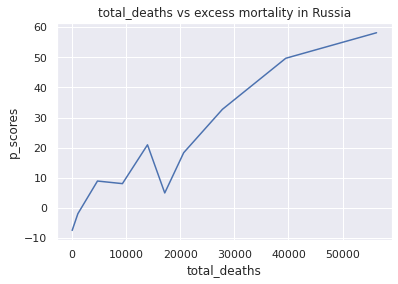

In [439]:
plot_col_against_excess_mortality('total_deaths', 'Russia')

Correlation (0.9717513865225957, 1.3510720435353683e-07)


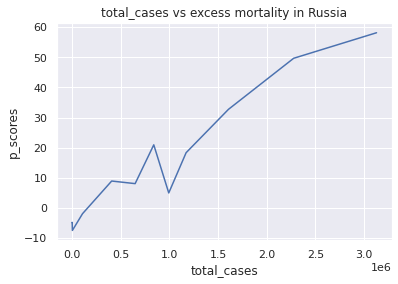

Correlation (0.49979715749580506, 0.0002195094585215334)


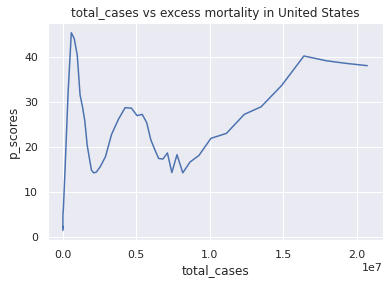

Correlation (0.7270183351771605, 4.814896744411234e-10)


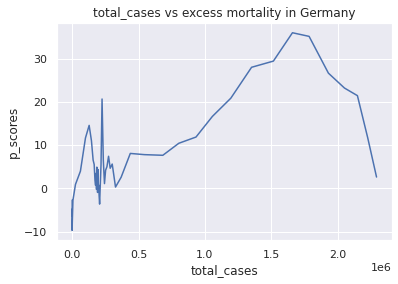

In [440]:
plot_col_against_excess_mortality('total_cases', 'Russia')
plot_col_against_excess_mortality('total_cases', 'United States')
plot_col_against_excess_mortality('total_cases', 'Germany')

In [449]:
countries = []
corrs_total_cases = []
corrs_total_deaths = []

for loc in df.location.unique():
    tdf = df[df.location == loc]
    tdf.index = tdf.date
    tdf = tdf[['date', 'total_cases', 'total_deaths']].dropna()
    tdf_mortality = mort_df[mort_df.location == loc].dropna()
    tdf_mortality.index = tdf_mortality.date

    intersect_dates = sorted(set(tdf_mortality.date).intersection(set(tdf.date)))
    total_cases = tdf['total_cases'].loc[intersect_dates]
    total_deaths = tdf['total_deaths'].loc[intersect_dates]
    p_scores = tdf_mortality.loc[intersect_dates].p_scores_all_ages
    
    if total_cases.empty or total_deaths.empty or p_scores.empty:
        continue
        
    countries.append(loc)
    corrs_total_cases.append(pearsonr(total_cases, p_scores)[0])
    corrs_total_deaths.append(pearsonr(total_deaths, p_scores)[0])

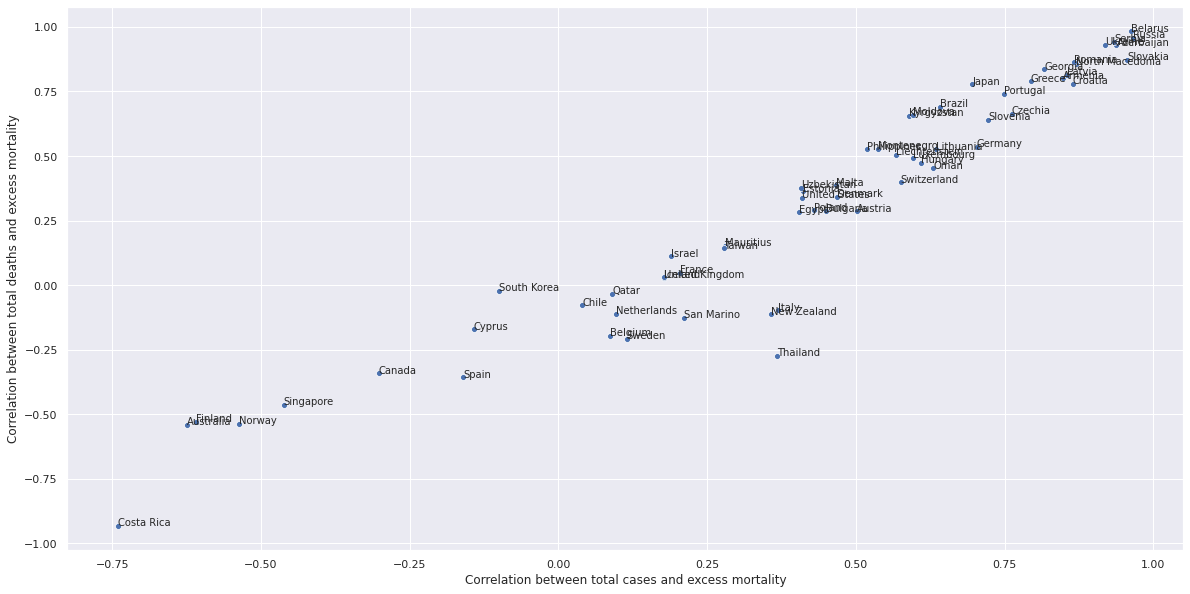

In [453]:
plt.figure(figsize=(20, 10))
sns.scatterplot(corrs_total_cases, corrs_total_deaths)

for i, txt in enumerate(countries):
    plt.annotate(txt, (corrs_total_cases[i], corrs_total_deaths[i]))
plt.xlabel("Correlation between total cases and excess mortality")
plt.ylabel("Correlation between total deaths and excess mortality")
plt.show()

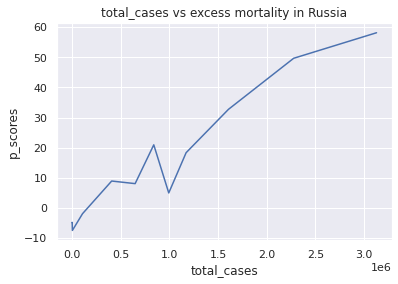

In [445]:
col = 'total_cases'
loc = 'Russia'
tdf = df[df.location == loc]
tdf.index = tdf.date
tdf_mortality = mort_df[mort_df.location == loc]

total_cases = tdf[col].loc[tdf_mortality.date]
p_scores = tdf_mortality.p_scores_all_ages

plt.title(f'{col} vs excess mortality in {loc}')
plt.plot(total_cases, p_scores)
plt.xlabel(col)
plt.ylabel('p_scores')
plt.show()

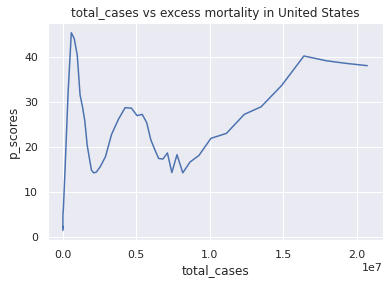

In [375]:
intersect_dates

[Timestamp('2020-01-26 00:00:00'),
 Timestamp('2020-02-02 00:00:00'),
 Timestamp('2020-02-09 00:00:00'),
 Timestamp('2020-02-16 00:00:00'),
 Timestamp('2020-02-23 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-03-08 00:00:00'),
 Timestamp('2020-03-15 00:00:00'),
 Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-03-29 00:00:00'),
 Timestamp('2020-04-05 00:00:00'),
 Timestamp('2020-04-12 00:00:00'),
 Timestamp('2020-04-19 00:00:00'),
 Timestamp('2020-04-26 00:00:00'),
 Timestamp('2020-05-03 00:00:00'),
 Timestamp('2020-05-10 00:00:00'),
 Timestamp('2020-05-17 00:00:00'),
 Timestamp('2020-05-24 00:00:00'),
 Timestamp('2020-05-31 00:00:00'),
 Timestamp('2020-06-07 00:00:00'),
 Timestamp('2020-06-14 00:00:00'),
 Timestamp('2020-06-21 00:00:00'),
 Timestamp('2020-06-28 00:00:00'),
 Timestamp('2020-07-05 00:00:00'),
 Timestamp('2020-07-12 00:00:00'),
 Timestamp('2020-07-19 00:00:00'),
 Timestamp('2020-07-26 00:00:00'),
 Timestamp('2020-08-02 00:00:00'),
 Timestamp('2020-08-

# Russian data

In [336]:
df[df.location == 'Russia'].shape

(390, 16)

In [320]:
df = df[df.location == 'Russia']
df.index = df.date
df.head()

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,new_tests,total_tests,new_tests_smoothed,positive_rate,tests_per_case,tests_units,population
date,,,,,,,,,,,,,,,,
2020-01-31,Russia,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
2020-02-01,Russia,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
2020-02-02,Russia,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
2020-02-03,Russia,2020-02-03,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
2020-02-04,Russia,2020-02-04,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0


In [321]:
df.head().T

date,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04
location,Russia,Russia,Russia,Russia,Russia
date,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04
total_cases,2,2,2,2,2
new_cases,2,0,0,0,0
new_cases_smoothed,NaN,NaN,NaN,NaN,NaN
total_deaths,NaN,NaN,NaN,NaN,NaN
new_deaths,NaN,NaN,NaN,NaN,NaN
new_deaths_smoothed,NaN,NaN,NaN,NaN,NaN
reproduction_rate,NaN,NaN,NaN,NaN,NaN
new_tests,NaN,NaN,NaN,NaN,NaN


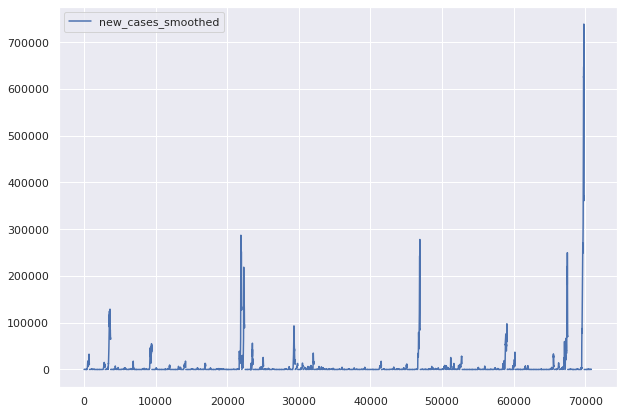

In [13]:
plt.figure(figsize=(10,7))
df.new_cases_smoothed.plot()
plt.legend()
plt.show()

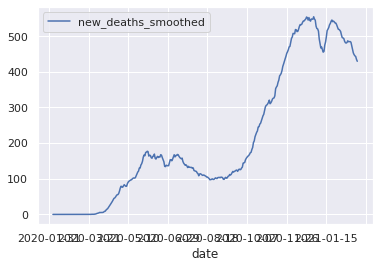

In [324]:
plt.figure()
df.new_deaths_smoothed.plot()
plt.legend()
plt.show()

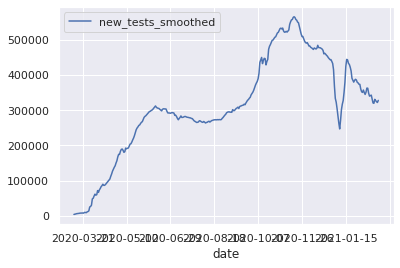

In [325]:
plt.figure()
df.new_tests_smoothed.plot()
plt.legend()
plt.show()

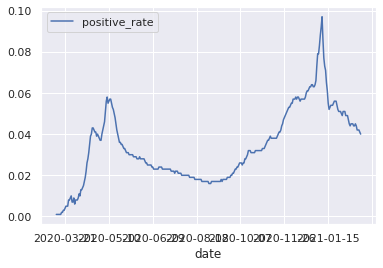

In [326]:
plt.figure()
df.positive_rate.plot()
plt.legend()
plt.show()

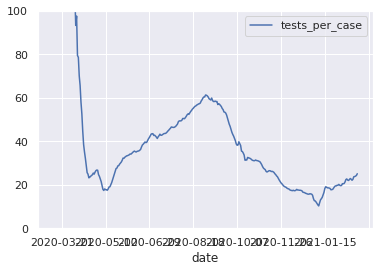

In [327]:
plt.figure()
df.tests_per_case.plot()
plt.ylim(0, 100)
plt.legend()
plt.show()

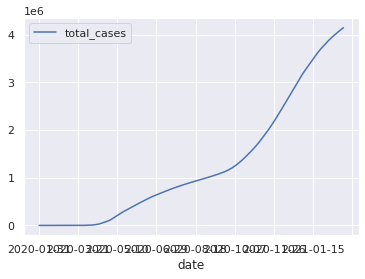

In [328]:
plt.figure()
df.total_cases.plot()
plt.legend()
plt.show()

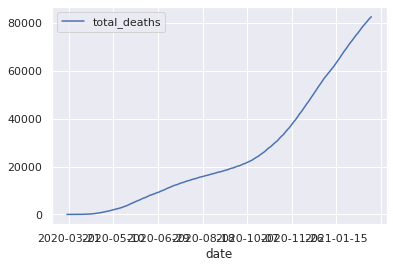

In [329]:
plt.figure()
df.total_deaths.plot()
plt.legend()
plt.show()

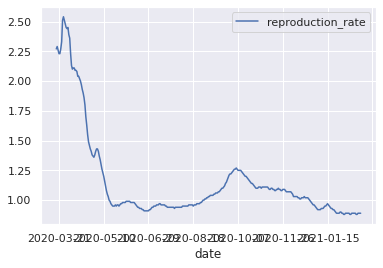

In [330]:
plt.figure()
df.reproduction_rate.plot()
plt.legend()
plt.show()

,0,1
location,Armenia,Armenia
date,2020-01-31 00:00:00,2020-02-29 00:00:00
p_scores_all_ages,-5.89,2.26
p_scores_15_64,NaN,NaN
p_scores_65_74,NaN,NaN
p_scores_75_84,NaN,NaN
p_scores_85plus,NaN,NaN
deaths_2020_all_ages,2567,2434
average_deaths_2015_2019_all_ages,2727.6,2380.2
deaths_2015_all_ages,2582,2363


,0,1
location,Armenia,Armenia
date,2020-01-31 00:00:00,2020-02-29 00:00:00
p_scores_all_ages,-5.89,2.26
time_unit,monthly,monthly


In [308]:
# Excess mortality vs total_cases